# Setup & Installs

In [2]:

!pip -q install kaggle==1.6.14 tensorflow==2.15.0 scikit-learn==1.4.2 matplotlib==3.8.4

import os, shutil, zipfile, random, pathlib
from google.colab import files

print("✅ Environment ready. Now upload your kaggle.json in the next cell.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.8 MB/s eta 0:00:00
ERROR: pip'

# Upload kaggle.json & set it up

In [4]:

from google.colab import files
import os, stat, json

print("📤 Please upload your kaggle.json file (Account > Create New API Token).")
uploaded = files.upload()

if 'kaggle.json' not in uploaded:
    raise RuntimeError("kaggle.json not uploaded. Please re-run and upload kaggle.json.")

os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'wb') as f:
    f.write(uploaded['kaggle.json'])

os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), stat.S_IRUSR | stat.S_IWUSR)
print("✅ kaggle.json configured.")


📤 Please upload your kaggle.json file (Account > Create New API Token).


Saving kaggle.json to kaggle.json
✅ kaggle.json configured.


# Download dataset from Kaggle (auto-fallback slugs)

In [5]:

import subprocess, os, zipfile, glob, shutil

# Candidate datasets (will try them in order until one works)
CANDIDATE_SLUGS = [
    # 4-class dataset with Training/Testing folders (commonly used)
    "sartaj/brain-tumor-classification-mri",
    # Binary yes/no dataset
    "navoneel/brain-mri-images-for-brain-tumor-detection",
    # Another 4-class dataset variants (fallbacks)
    "preetviradiya/brian-tumor-dataset",
    "ahmedhamada0/brain-tumor-detection",
]

DATA_ROOT = "/content/data"
os.makedirs(DATA_ROOT, exist_ok=True)

downloaded_zip = None
used_slug = None

for slug in CANDIDATE_SLUGS:
    try:
        print(f"⬇️ Trying to download: {slug}")
        # Clean previous attempts
        for f in glob.glob(os.path.join(DATA_ROOT, "*.zip")):
            os.remove(f)
        # Download
        subprocess.run(
            ["kaggle", "datasets", "download", "-d", slug, "-p", DATA_ROOT],
            check=True, capture_output=True
        )
        zips = glob.glob(os.path.join(DATA_ROOT, "*.zip"))
        if not zips:
            continue
        downloaded_zip = zips[0]
        used_slug = slug
        print(f"✅ Downloaded: {slug}")
        break
    except subprocess.CalledProcessError as e:
        print(f"⚠️ Failed: {slug} -> {e}")
        continue

if not downloaded_zip:
    raise RuntimeError("Unable to download any dataset. Please update the slug list or check Kaggle access.")

# Unzip to a dedicated folder
EXTRACT_DIR = "/content/dataset"
if os.path.exists(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)
os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(downloaded_zip, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

print(f"📦 Extracted to {EXTRACT_DIR}")
print(f"ℹ️ Using dataset: {used_slug}")


⬇️ Trying to download: sartaj/brain-tumor-classification-mri
⚠️ Failed: sartaj/brain-tumor-classification-mri -> Command '['kaggle', 'datasets', 'download', '-d', 'sartaj/brain-tumor-classification-mri', '-p', '/content/data']' returned non-zero exit status 1.
⬇️ Trying to download: navoneel/brain-mri-images-for-brain-tumor-detection
✅ Downloaded: navoneel/brain-mri-images-for-brain-tumor-detection
📦 Extracted to /content/dataset
ℹ️ Using dataset: navoneel/brain-mri-images-for-brain-tumor-detection


# Discover folders (train/test) automatically


In [6]:

import os, glob, shutil, random

def find_split_dirs(root):
    # Try common patterns:
    candidates = [
        ("Training", "Testing"),
        ("train", "test"),
        ("Train", "Test"),
        ("TRAIN", "TEST")
    ]
    for tr, te in candidates:
        train_dir = os.path.join(root, tr)
        test_dir  = os.path.join(root, te)
        if os.path.isdir(train_dir) and os.path.isdir(test_dir):
            return train_dir, test_dir
    return None, None

train_dir, test_dir = find_split_dirs("/content/dataset")

# If not found, try to locate a single root with class subfolders and then split it
if train_dir is None or test_dir is None:
    print("ℹ️ No explicit train/test folders found. Will create a split.")
    # Try to guess a single folder that contains class subfolders
    # Find the deepest folder that has multiple subfolders with images
    def has_images(p):
        exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
        for root, dirs, files in os.walk(p):
            for f in files:
                if f.lower().endswith(exts):
                    return True
        return False

    # Candidates: any folder under /content/dataset that contains images and subfolders
    roots = [p for p in glob.glob("/content/dataset/*") if os.path.isdir(p)]
    if not roots:
        roots = ["/content/dataset"]

    chosen_root = None
    for r in roots:
        subdirs = [d for d in glob.glob(os.path.join(r, "*")) if os.path.isdir(d)]
        if len(subdirs) >= 2 and any(has_images(sd) for sd in subdirs):
            chosen_root = r
            break

    if chosen_root is None:
        raise RuntimeError("Could not find a suitable root with class subfolders.")

    # Make split 85/15 for train/test
    train_dir = "/content/dataset_split/train"
    test_dir  = "/content/dataset_split/test"
    if os.path.exists("/content/dataset_split"):
        shutil.rmtree("/content/dataset_split")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    class_dirs = [d for d in glob.glob(os.path.join(chosen_root, "*")) if os.path.isdir(d)]
    for cdir in class_dirs:
        cls = os.path.basename(cdir)
        imgs = []
        for root, dirs, files in os.walk(cdir):
            for f in files:
                if f.lower().endswith((".png",".jpg",".jpeg",".bmp",".tif",".tiff")):
                    imgs.append(os.path.join(root, f))
        random.shuffle(imgs)
        if len(imgs) == 0:
            continue
        split_idx = max(1, int(0.85 * len(imgs)))
        tr_imgs = imgs[:split_idx]
        te_imgs = imgs[split_idx:]
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
        # Copy
        for src in tr_imgs:
            shutil.copy2(src, os.path.join(train_dir, cls, os.path.basename(src)))
        for src in te_imgs:
            shutil.copy2(src, os.path.join(test_dir, cls, os.path.basename(src)))

print(f"✅ Train dir: {train_dir}")
print(f"✅ Test dir : {test_dir}")


ℹ️ No explicit train/test folders found. Will create a split.
✅ Train dir: /content/dataset_split/train
✅ Test dir : /content/dataset_split/test


# Data pipeline & hyperparameters

In [10]:

import tensorflow as tf
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 1337

# AutoTune
AUTOTUNE = tf.data.AUTOTUNE

train_full = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    label_mode='categorical',
    shuffle=False
)

class_names = train_full.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# Optional validation split from train
VAL_FRACTION = 0.15
val_batches = tf.data.experimental.cardinality(train_full).numpy()
val_size = max(1, int(VAL_FRACTION * val_batches))

val_ds = train_full.take(val_size)
train_ds = train_full.skip(val_size)

# Prefetch for speed
def prepare(ds, training=False):
    if training:
        ds = ds.shuffle(1024, seed=SEED)
    return ds.prefetch(AUTOTUNE)

train_ds = prepare(train_ds, training=True)
val_ds   = prepare(val_ds, training=False)
test_ds  = prepare(test_ds, training=False)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.08),
], name="augmentation")


Found 214 files belonging to 2 classes.
Found 39 files belonging to 2 classes.
Classes: ['no', 'yes']


# Build ResNet50 transfer model

In [11]:

from tensorflow.keras import layers, models

base = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base.trainable = False  # start with frozen base

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation        │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ augmentation[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ augmentation[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │      4,098 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Callbacks & Training


In [12]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

BEST_PATH = "/content/best_resnet50.h5"

ckpt = ModelCheckpoint(
    BEST_PATH, monitor="val_accuracy", save_best_only=True,
    save_weights_only=False, mode="max", verbose=1
)
early = EarlyStopping(
    monitor="val_accuracy", patience=6, mode="max",
    restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3,
    min_lr=1e-6, verbose=1
)

EPOCHS_STAGE1 = 12
history1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=[ckpt, early, reduce_lr],
    verbose=1
)
print("✅ Stage 1 done. Best model saved to:", BEST_PATH)


Epoch 1/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.5083 - loss: 1.0504
Epoch 1: val_accuracy improved from -inf to 0.53125, saving model to /content/best_resnet50.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 938ms/step - accuracy: 0.5102 - loss: 1.0363 - val_accuracy: 0.5312 - val_loss: 0.7014 - learning_rate: 0.0010
Epoch 2/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6378 - loss: 0.7053
Epoch 2: val_accuracy improved from 0.53125 to 0.81250, saving model to /content/best_resnet50.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - accuracy: 0.6369 - loss: 0.7086 - val_accuracy: 0.8125 - val_loss: 0.4851 - learning_rate: 0.0010
Epoch 3/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6292 - loss: 0.7884
Epoch 3: val_accuracy did not improve from 0.81250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.6296 - loss: 0.7793 - val_accuracy: 0.3438 - val_loss: 1.1440 - learning_rate: 0.0010
Epoch 4/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6496 - loss: 0.7164
Epoch 4: val_accuracy improved from 0.81250 to 0.90625, saving model to /content/best_resnet50.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.6597 - loss: 0.7037 - val_accuracy: 0.9062 - val_loss: 0.2911 - learning_rate: 0.0010
Epoch 5/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7717 - loss: 0.4977
Epoch 5: val_accuracy did not improve from 0.90625
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.7722 - loss: 0.5000 - val_accuracy: 0.7500 - val_loss: 0.4936 - learning_rate: 0.0010
Epoch 6/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7343 - loss: 0.5096
Epoch 6: val_accuracy did not improve from 0.90625
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.7353 - loss: 0.5103 - val_accuracy: 0.7188 - val_loss: 0.4847 - learning_rate: 0.0010
Epoch 7/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7704 - loss: 0.4520
Epoch 7: val_accuracy improved from 0.90625 to 0.96875, saving model to /content/best_resnet50.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - accuracy: 0.7726 - loss: 0.4505 - val_accuracy: 0.9688 - val_loss: 0.1970 - learning_rate: 0.0010
Epoch 8/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8714 - loss: 0.3462
Epoch 8: val_accuracy did not improve from 0.96875
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.8709 - loss: 0.3460 - val_accuracy: 0.9375 - val_loss: 0.3116 - learning_rate: 0.0010
Epoch 9/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8416 - loss: 0.3879
Epoch 9: val_accuracy did not improve from 0.96875
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.8423 - loss: 0.3889 - val_accuracy: 0.9062 - val_loss: 0.2681 - learning_rate: 0.0010
Epoch 10/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8625 - loss: 0.3042
Epoch 10: val_accuracy did not improve from 0.96875

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.8625 - loss: 0.3053 - val_accuracy: 0.9062 - 

# Fine-tuning


In [20]:

# Unfreeze last ~50 layers except BN
def unfreeze_model(base_model, num_unfreeze=50):
    # Unfreeze from the end
    ct = 0
    for layer in reversed(base_model.layers):
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
            continue
        if ct < num_unfreeze:
            layer.trainable = True
            ct += 1
        else:
            layer.trainable = False

unfreeze_model(base, num_unfreeze=50)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_STAGE2 = 15
history2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=[ckpt, early, reduce_lr],
    verbose=1
)
print("✅ Stage 2 done. Best model updated if improved.")


Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8738 - loss: 0.2809
Epoch 1: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8761 - loss: 0.2764 - val_accuracy: 0.9375 - val_loss: 0.0945 - learning_rate: 5.0000e-05
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9609 - loss: 0.1443
Epoch 2: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.9618 - loss: 0.1401 - val_accuracy: 0.9688 - val_loss: 0.1262 - learning_rate: 5.0000e-05
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9647 - loss: 0.0973
Epoch 3: val_accuracy did not improve from 1.00000
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.9666 - loss: 0.0949 - val_accuracy: 0.9375 - val_loss: 0.1674 - learning_rate: 5.0000e-05
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9682 - loss: 0.0842
Epoch 4: val_accuracy did not improve from 1.00000

Epoch 4: ReduceLROnPlateau reduc

#  Evaluate & confusion matrix


📊 Test Accuracy: 92.31%

Classification Report:

              precision    recall  f1-score   support

          no     0.8750    0.9333    0.9032        15
         yes     0.9565    0.9167    0.9362        24

    accuracy                         0.9231        39
   macro avg     0.9158    0.9250    0.9197        39
weighted avg     0.9252    0.9231    0.9235        39



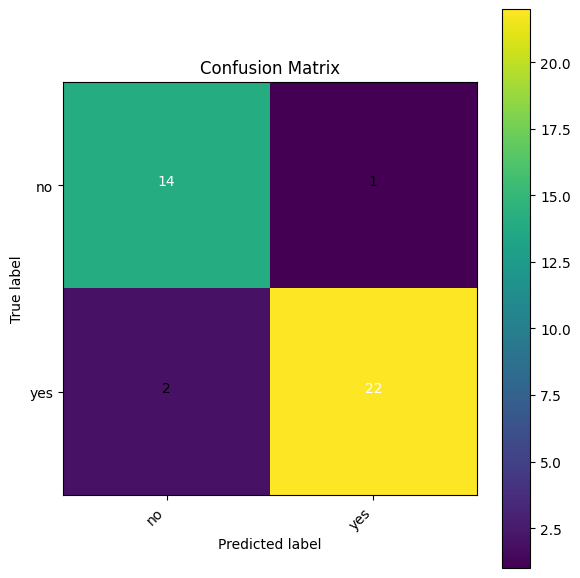

In [25]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow.keras import layers, models

# --- إعادة بناء نفس الموديل (ResNet50 backbone + Dense layer) ---
base = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet",
    input_shape=(224,224,3)
)
base.trainable = False

inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
best_model = models.Model(inputs, outputs)

# --- تحميل الأوزان من ملف BEST_PATH ---
best_model.load_weights(BEST_PATH)

best_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Evaluate ---
test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
print(f"📊 Test Accuracy: {test_acc*100:.2f}%")

# --- Predictions ---
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_true_idx = np.argmax(y_true, axis=1)

y_pred_probs = best_model.predict(test_ds, verbose=0)
y_pred_idx = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_idx, y_pred_idx, target_names=class_names, digits=4))

cm = confusion_matrix(y_true_idx, y_pred_idx)

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, class_names)
plt.show()


#  Visual check on random test images (pred)


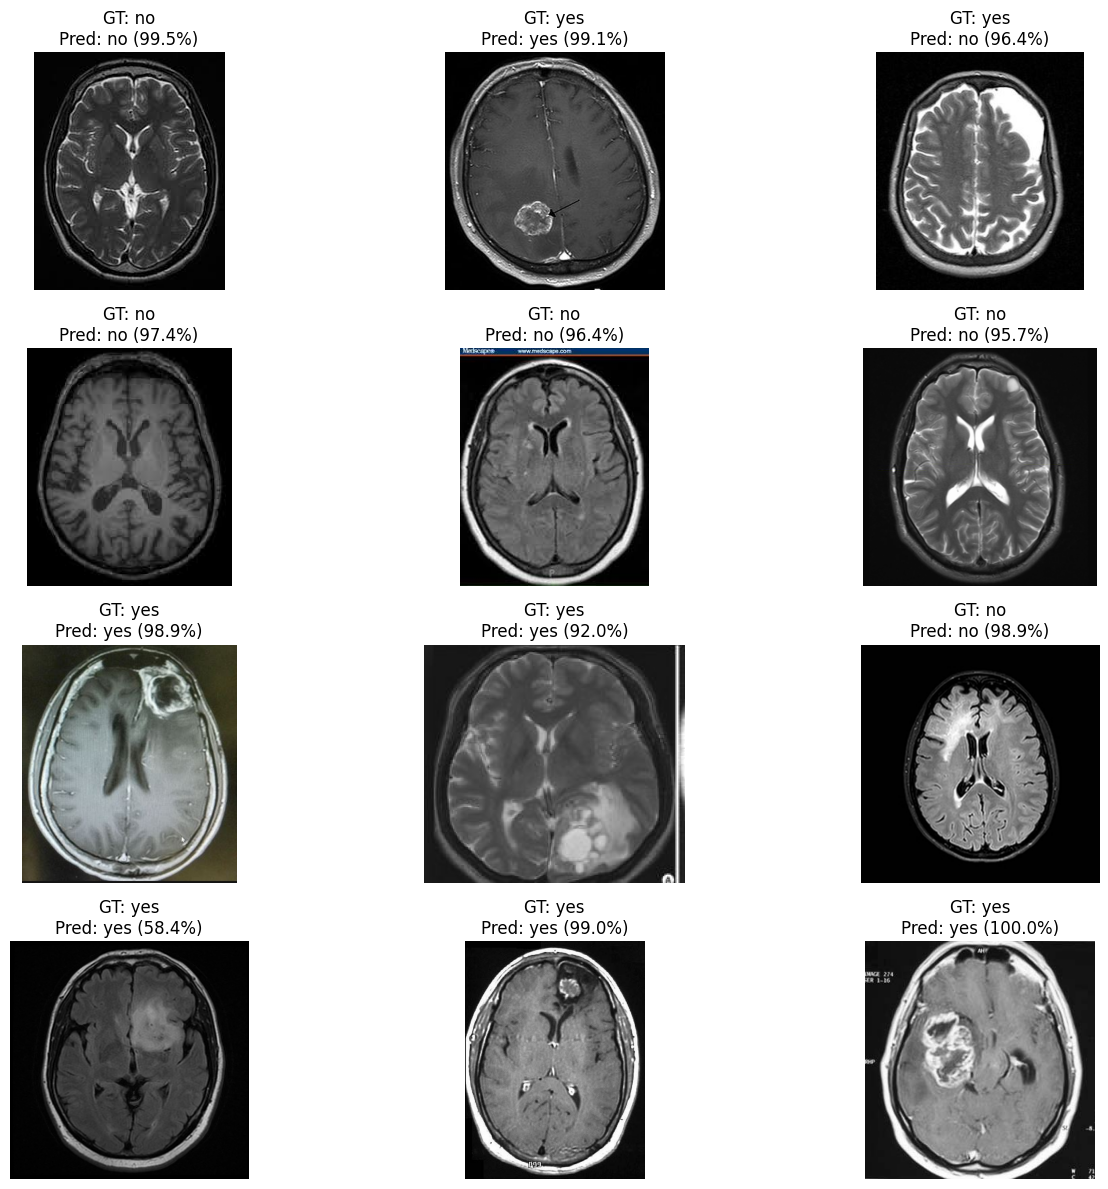

In [28]:

import matplotlib.pyplot as plt
import os, random
import numpy as np
from tensorflow.keras.preprocessing import image

# Collect test images by class
def list_images(root):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    paths = []
    for cls in sorted(os.listdir(root)):
        cpath = os.path.join(root, cls)
        if not os.path.isdir(cpath):
            continue
        for f in os.listdir(cpath):
            if f.lower().endswith(exts):
                paths.append((os.path.join(cpath, f), cls))
    return paths

samples = list_images(test_dir)
random.shuffle(samples)
samples = samples[:12] if len(samples) >= 12 else samples

plt.figure(figsize=(14, 12))
for i, (img_path, true_cls) in enumerate(samples, start=1):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)
    preds = best_model.predict(x, verbose=0)[0]
    pred_idx = np.argmax(preds)
    pred_cls = class_names[pred_idx]
    conf = preds[pred_idx] * 100

    plt.subplot(4, 3, i)
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"GT: {true_cls}\nPred: {pred_cls} ({conf:.1f}%)")
plt.tight_layout()
plt.show()


# Download best model to your local device


In [29]:

from google.colab import files

FINAL_PATH = "/content/brain_tumor_resnet50_best.h5"
# Ensure the best checkpoint is copied with a nice name
shutil.copy2(BEST_PATH, FINAL_PATH)
print("✅ Best model at:", FINAL_PATH)

# Trigger download
files.download(FINAL_PATH)


✅ Best model at: /content/brain_tumor_resnet50_best.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
EXPORT_PATH = "/content/brain_tumor_resnet50_saved"
best_model.export(EXPORT_PATH)   
print("✅ Model exported at:", EXPORT_PATH)


Saved artifact at '/content/brain_tumor_resnet50_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_547')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  136578481473104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136578481484240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136578480031696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136578480032272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575316082512: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136578481474256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136578481482512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575309155600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575309157136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575309155792: TensorSpec(shape=(), dtype=tf.resou

In [33]:
EXPORT_PATH = "/content/brain_tumor_resnet50_saved"
best_model.export(EXPORT_PATH)   # ✅ Keras 3 export

import shutil
shutil.make_archive(EXPORT_PATH, 'zip', EXPORT_PATH)

from google.colab import files
files.download(EXPORT_PATH + ".zip")


Saved artifact at '/content/brain_tumor_resnet50_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_547')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  136578481473104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136578481484240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136578480031696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136578480032272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575316082512: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  136578481474256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136578481482512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575309155600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575309157136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136575309155792: TensorSpec(shape=(), dtype=tf.resou

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
best_model.save("/content/brain_tumor_resnet50.keras")

from google.colab import files
files.download("/content/brain_tumor_resnet50.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image(80).jpg to image(80).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


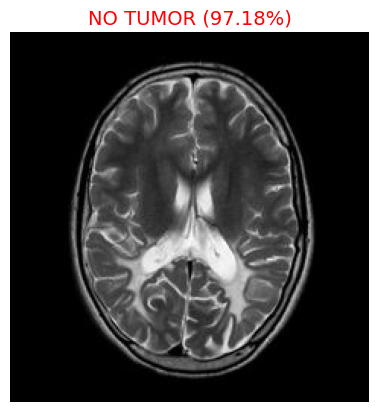

In [52]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt

# --- Load model ---
model = load_model(MODEL_PATH)

# Class labels
class_names = ["NO TUMOR", "TUMOR"]

def predict_tumor(img_path):
    # Load & preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.resnet50.preprocess_input(x)

    # Predict
    preds = model.predict(x)
    prob = float(np.max(preds)) * 100
    pred_class = class_names[np.argmax(preds)]

    return pred_class, prob

# --- Upload image interactively ---
uploaded = files.upload()

for fname in uploaded.keys():
    label, confidence = predict_tumor(fname)

    img = image.load_img(fname)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} ({confidence:.2f}%)", fontsize=14, color="red")
    plt.show()
